## ML2 TP FINAL

https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [0]:
import mlflow
import mlflow.pyfunc
from mlflow.pyfunc import PythonModelContext

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import missingno as msno
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.svm import SVC

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.feature_selection import f_regression, SelectKBest, mutual_info_regression, mutual_info_classif, RFE, SelectFromModel, SequentialFeatureSelector
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.feature_selection import f_regression, SelectKBest

pd.set_option("display.max_columns", None)
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

## Cargar BD de dataset de entrenamiento

In [0]:
df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://34.134.192.243:5432/ml2") \
    .option("dbtable", "heart_table") \
    .option("user", "postgres") \
    .option("password", "vjoDsrpnzad7rlnG") \
    .option("driver", "org.postgresql.Driver") \
    .load()

df.printSchema()

root
-- id: long (nullable = true)
-- Age: integer (nullable = true)
-- Sex: string (nullable = true)
-- ChestPainType: string (nullable = true)
-- RestingBP: integer (nullable = true)
-- Cholesterol: integer (nullable = true)
-- FastingBS: integer (nullable = true)
-- RestingECG: string (nullable = true)
-- MaxHR: integer (nullable = true)
-- ExerciseAngina: string (nullable = true)
-- Oldpeak: double (nullable = true)
-- ST_Slope: string (nullable = true)
-- HeartDisease: integer (nullable = true)

## Exploración de los datos

In [0]:
heart_df = df.toPandas().drop(columns=['id'])
print('Dimension dataset: ', heart_df.shape)

Dimension dataset: (918, 12)

In [0]:
heart_df.head()

Out[14]:

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [0]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Age 918 non-null int32 
 1 Sex 918 non-null object 
 2 ChestPainType 918 non-null object 
 3 RestingBP 918 non-null int32 
 4 Cholesterol 918 non-null int32 
 5 FastingBS 918 non-null int32 
 6 RestingECG 918 non-null object 
 7 MaxHR 918 non-null int32 
 8 ExerciseAngina 918 non-null object 
 9 Oldpeak 918 non-null float64
 10 ST_Slope 918 non-null object 
 11 HeartDisease 918 non-null int32 
dtypes: float64(1), int32(6), object(5)
memory usage: 64.7+ KB

In [0]:
numeric_features = heart_df.select_dtypes(exclude=['category', object]).columns.values 
categorical_features = heart_df.select_dtypes(include=['category', object]).columns.values

In [0]:
heart_df.isnull().sum()

Out[17]: Age 0
Sex 0
ChestPainType 0
RestingBP 0
Cholesterol 0
FastingBS 0
RestingECG 0
MaxHR 0
ExerciseAngina 0
Oldpeak 0
ST_Slope 0
HeartDisease 0
dtype: int64

In [0]:
heart_df.describe()

Out[18]:

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [0]:
heart_df = heart_df[heart_df['RestingBP'] != 0]
heart_df = heart_df[heart_df['Cholesterol'] != 0]
print(heart_df.shape)

(746, 12)

Out[7]:

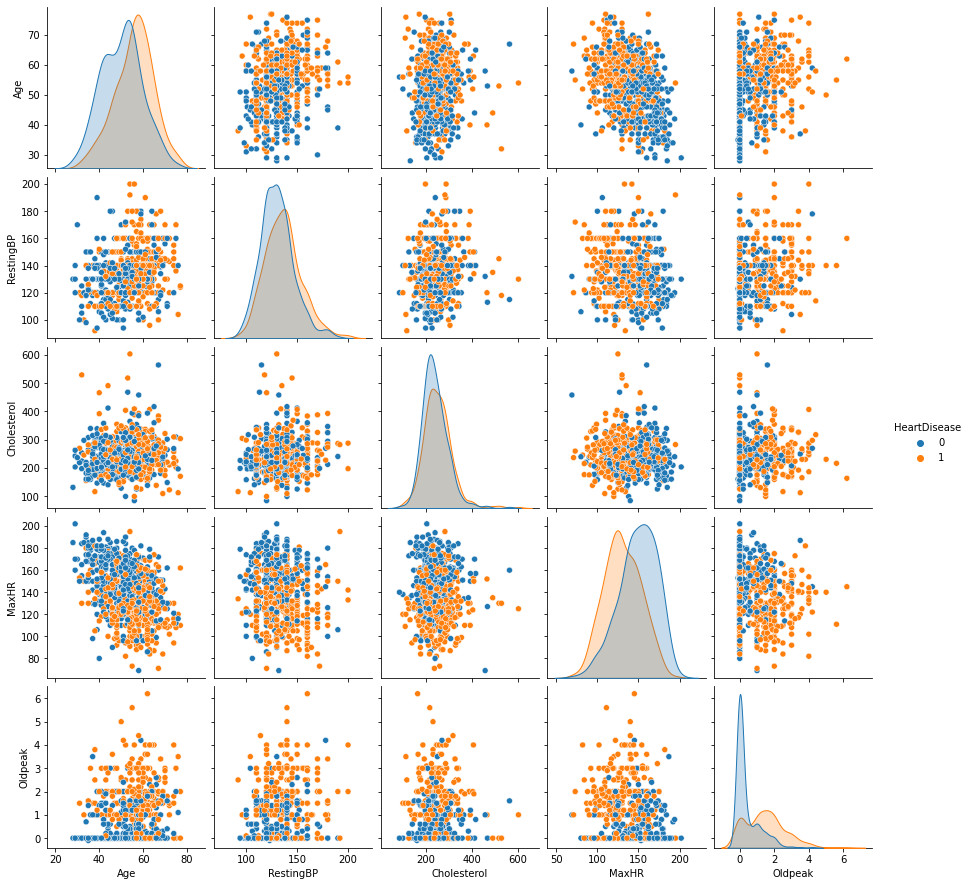

<seaborn.axisgrid.PairGrid at 0x7ffbb5a5c1f0>

In [0]:
sns.pairplot(heart_df[numeric_features[~np.isin(numeric_features, ['FastingBS'])]], hue='HeartDisease')

Out[8]:

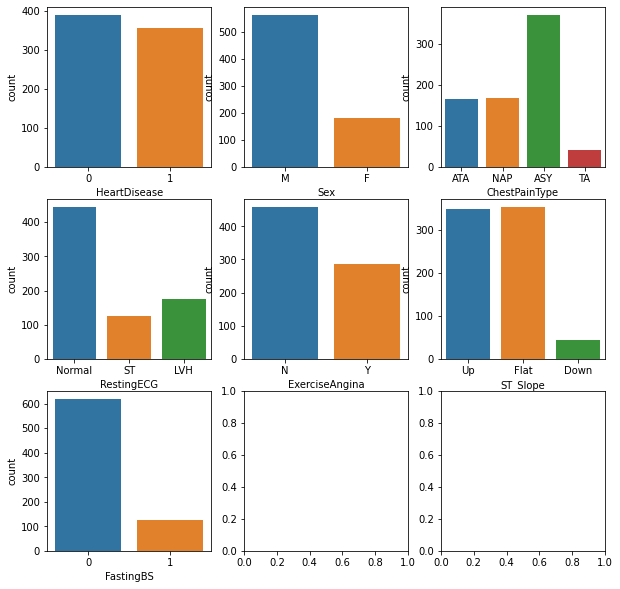

<AxesSubplot:xlabel='FastingBS', ylabel='count'>

In [0]:
fig, axes=plt.subplots(3,3, figsize=(10, 10))
sns.countplot(x = 'HeartDisease', data = heart_df, ax=axes[0,0])
sns.countplot(x = 'Sex', data = heart_df, ax=axes[0,1])
sns.countplot(x = 'ChestPainType', data = heart_df, ax=axes[0,2])
sns.countplot(x = 'RestingECG', data = heart_df, ax=axes[1,0])
sns.countplot(x = 'ExerciseAngina', data = heart_df, ax=axes[1,1])
sns.countplot(x = 'ST_Slope', data = heart_df, ax=axes[1,2])
sns.countplot(x = 'FastingBS', data = heart_df, ax=axes[2,0])

Out[9]:

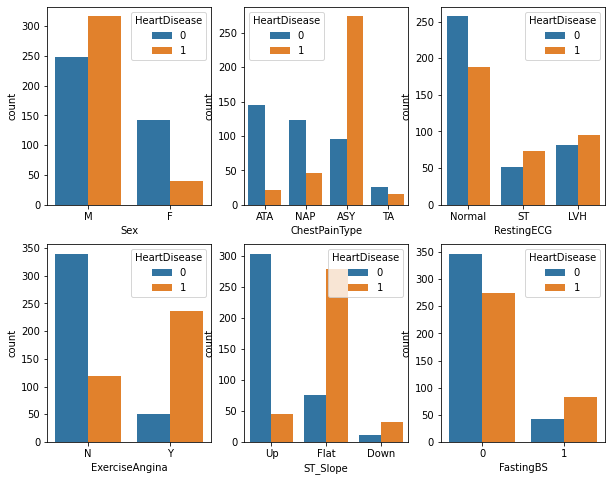

<AxesSubplot:xlabel='FastingBS', ylabel='count'>

In [0]:
fig, axes=plt.subplots(2,3, figsize=(10, 8))
sns.countplot(x = 'Sex', data = heart_df, ax=axes[0,0], hue='HeartDisease')
sns.countplot(x = 'ChestPainType', data = heart_df, ax=axes[0,1], hue='HeartDisease')
sns.countplot(x = 'RestingECG', data = heart_df, ax=axes[0,2], hue='HeartDisease')
sns.countplot(x = 'ExerciseAngina', data = heart_df, ax=axes[1,0], hue='HeartDisease')
sns.countplot(x = 'ST_Slope', data = heart_df, ax=axes[1,1], hue='HeartDisease')
sns.countplot(x = 'FastingBS', data = heart_df, ax=axes[1,2], hue='HeartDisease')

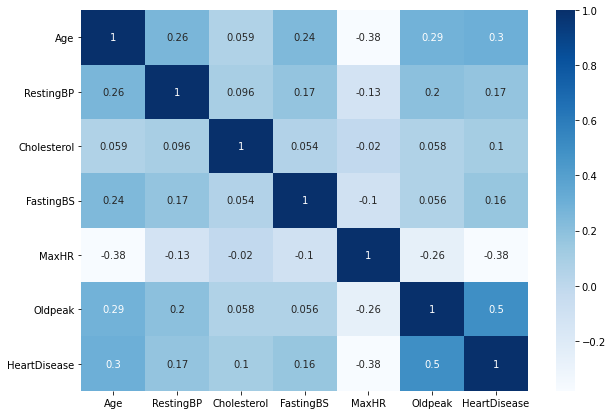

In [0]:
plt.figure(figsize=(10,7))
sns.heatmap(heart_df.corr(), annot=True,cmap='Blues')
plt.show()

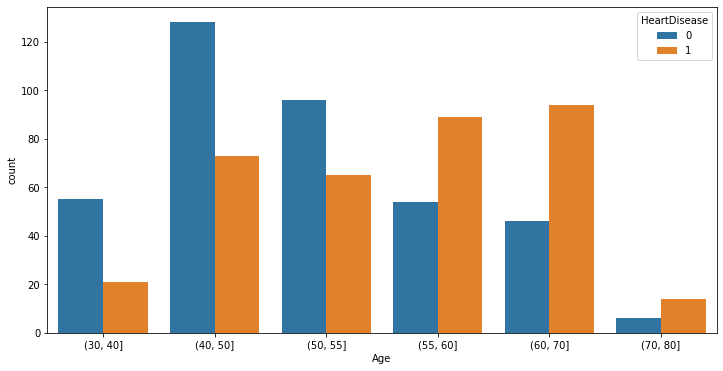

In [0]:
plt.figure(figsize=(12,6))
bins=[30,40,50,55,60,70,80]
sns.countplot(x=pd.cut(heart_df.Age,bins=bins),hue=heart_df.HeartDisease)
plt.show()

In [0]:
Ytotal_df = heart_df['HeartDisease']
Xtotal_df = heart_df.drop(columns=["HeartDisease"])

## Partición de datos en entrenamiento y prueba

In [0]:
XTrain_df, XTest_df, yTrain_df, yTest_df = train_test_split(Xtotal_df, Ytotal_df, test_size=0.33, random_state=0, 
                                                            stratify=Ytotal_df)

### Codificacion de variables categoricas

In [0]:
# funciones util
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=int)
        X_mask = np.ones_like(X, dtype=bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

# A class to select numerical or categorical columns
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [0]:
##
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'] 
       
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']

numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(numeric_features)),
])

categorical_pipeline= Pipeline([
    ("select_cat", DataFrameSelector(categorical_features)),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

preprocess_pipeline = FeatureUnion(transformer_list=[
    ("numerical_pipeline", numerical_pipeline),             
    ("categorical_pipeline", categorical_pipeline),
])

##
#
XTrain = preprocess_pipeline.fit_transform(XTrain_df)
#

XTest = preprocess_pipeline.transform(XTest_df)

columns_ohe = np.array([])
for i,val in enumerate(preprocess_pipeline.transformer_list[1][1][1].categories_):
  columns_ohe = np.append(columns_ohe, categorical_features[i]+"_"+val)

columns_ohe = columns_ohe.tolist()

XTrain_enc_df = pd.DataFrame(XTrain, columns=(numeric_features+columns_ohe))
XTest_enc_df = pd.DataFrame(XTest, columns=(numeric_features+columns_ohe))

# dummy encoding, drop first column
XTrain_df = XTrain_enc_df.drop(columns=['Sex_F', 'ChestPainType_ASY', 'RestingECG_LVH','ExerciseAngina_N', 'ST_Slope_Down'])
XTest_df = XTest_enc_df.drop(columns=['Sex_F', 'ChestPainType_ASY', 'RestingECG_LVH','ExerciseAngina_N', 'ST_Slope_Down'])

2022/04/23 05:40:46 WARNING mlflow.utils: Truncated the value of the key `transformer_list`. Truncated value: `[('numerical_pipeline', Pipeline(steps=[('select_numeric',
 DataFrameSelector(attribute_names=['Age', 'RestingBP',
 'Cholesterol', 'MaxHR',
 ...`
2022/04/23 05:40:46 WARNING mlflow.utils: Truncated the value of the key `numerical_pipeline`. Truncated value: `Pipeline(steps=[('select_numeric',
 DataFrameSelector(attribute_names=['Age', 'RestingBP',
 'Cholesterol', 'MaxHR',
 'Oldpeak', '...`
2022/04/23 05:40:46 WARNING mlflow.utils: Truncated the value of the key `categorical_pipeline`. Truncated value: `Pipeline(steps=[('select_cat',
 DataFrameSelector(attribute_names=['Sex', 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 ...`
2022/04/23 05:40:46 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/04/23 05:40:46 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2022/04/23 05:40:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException("Failed to perform one or more operations on the run with ID b7be2e95b88b48fd84e2b3dd5c08776d. Failed operations: [RestException('INVALID_PARAMETER_VALUE: Parameter with key verbose was already logged with a value of 0. The attempted new value was False')]")]

In [0]:
def pre_processing(input_df, pipeline, num_features):
    
    input_df2 = pipeline.transform(input_df)
    
    columns_ohe = np.array([])
    for i,val in enumerate(pipeline.transformer_list[1][1][1].categories_):
      columns_ohe = np.append(columns_ohe, categorical_features[i]+"_"+val)

    columns_ohe = columns_ohe.tolist()

    x = pd.DataFrame(input_df2, columns=(num_features+columns_ohe))
    
    # dummy encoding, drop first column
    return x.drop(columns=['Sex_F', 'ChestPainType_ASY', 'RestingECG_LVH','ExerciseAngina_N', 'ST_Slope_Down'])
    
    

In [0]:
XTrain_df.head()

Out[24]:

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,FastingBS,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,63.0,140.0,195.0,179.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,62.0,160.0,164.0,145.0,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,54.0,130.0,294.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
3,62.0,135.0,297.0,130.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,70.0,170.0,192.0,129.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [0]:
XTest_df.head()

Out[25]:

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,FastingBS,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,61.0,120.0,337.0,98.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1,46.0,140.0,311.0,120.0,1.8,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,59.0,180.0,213.0,100.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,69.0,122.0,216.0,84.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,70.0,156.0,245.0,143.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Balanceo de datos

In [0]:
print(f"Distribucion de clases antes del SMOTE: \n{yTrain_df.value_counts()}")

cat_variables_idx = [5,6,7,8,9,10,11,12,13,14]

oversample = SMOTENC(categorical_features=cat_variables_idx, sampling_strategy='all')
XTrain_df, yTrain_df = oversample.fit_resample(XTrain_df,yTrain_df)

print(f"Distribucion de clases despues del SMOTE: \n{yTrain_df.value_counts()}")

Distribucion de clases antes del SMOTE: 
0 261
1 238
Name: HeartDisease, dtype: int64
2022/04/23 05:17:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1c0f9ab17c1d4378b15ab361a5357498', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/04/23 05:17:00 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/04/23 05:17:00 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
Distribucion de clases despues del SMOTE: 
0 261
1 261
Name: HeartDisease, dtype: int64

## Selección y Extracción de variables:

Out[44]:

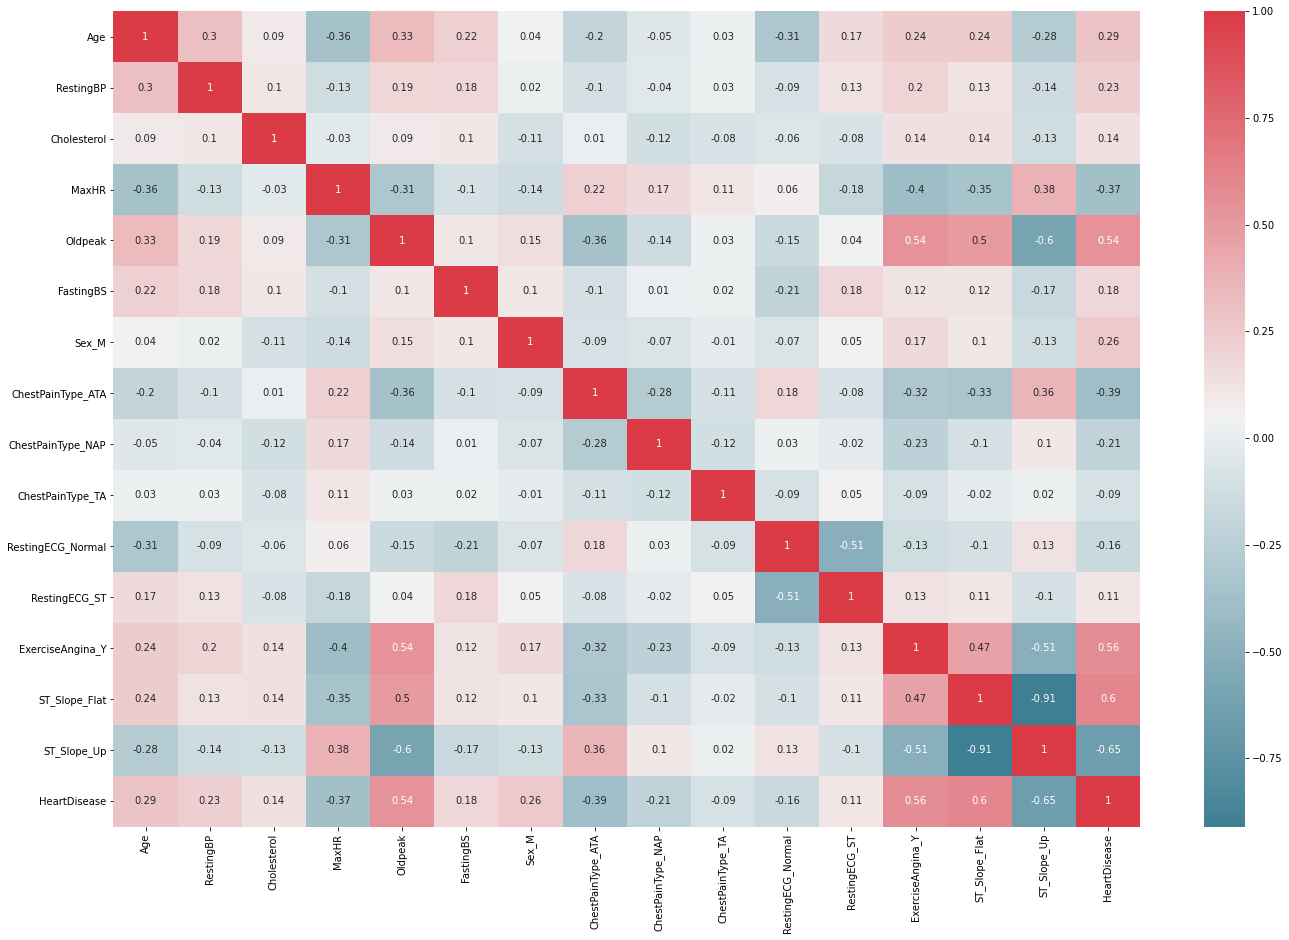

<AxesSubplot:>

In [0]:
train_all_df = pd.concat([XTrain_df, pd.DataFrame(yTrain_df).reset_index(drop=True)], axis=1)

correlation_matrix = train_all_df.corr(method='spearman').round(2)
fig,axes = plt.subplots(1,1,figsize=(23,15))
sns.heatmap(data=correlation_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True,ax=axes)

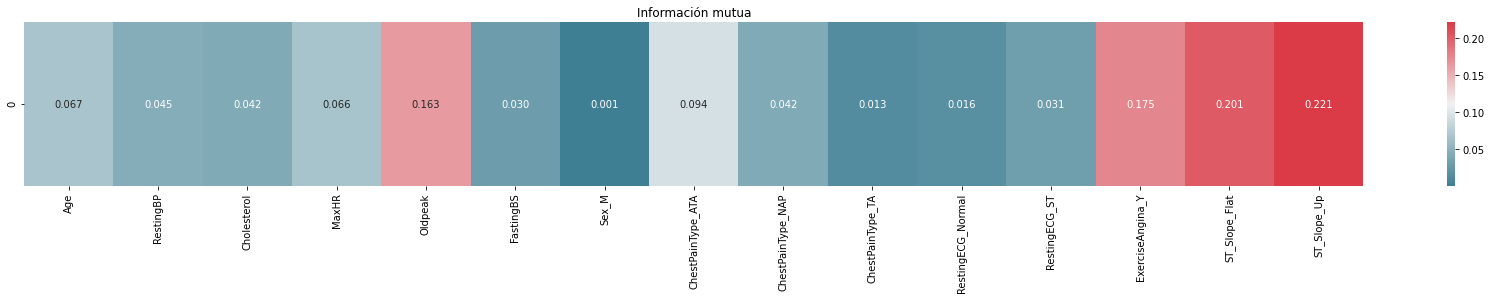

In [0]:
mu_inf = mutual_info_classif(XTrain_df, yTrain_df.values,discrete_features=False)

fig, ax = plt.subplots(1,1, figsize=(30,3))
ax.set_title('Información mutua')
sns.heatmap([mu_inf],ax=ax,cmap=sns.diverging_palette(220,10,as_cmap=True), annot=True,fmt=".3f")
ax.set_xticklabels(XTrain_df.columns.to_list())
ax.tick_params(axis='x', rotation=90)

In [0]:
selectKbest_mi = SelectKBest(mutual_info_classif, k=12)
selectKbest_mi.fit(XTrain_df, yTrain_df)

print("Variables seleccionadas: {}".format(XTrain_df.columns.to_numpy()[selectKbest_mi.get_support()]))

Variables seleccionadas: ['Age' 'RestingBP' 'Cholesterol' 'MaxHR' 'Oldpeak' 'FastingBS' 'Sex_M'
 'ChestPainType_ATA' 'ChestPainType_NAP' 'ExerciseAngina_Y'
 'ST_Slope_Flat' 'ST_Slope_Up']

In [0]:
#SelectFromModel
selector_sfm = SelectFromModel(estimator=RandomForestClassifier())
selector_sfm.fit(XTrain_df, yTrain_df)

print("variables seleccionadas: {}".format(XTrain_df.columns.to_numpy()[selector_sfm.get_support()]))


variables seleccionadas: ['Age' 'RestingBP' 'Cholesterol' 'MaxHR' 'Oldpeak' 'ExerciseAngina_Y'
 'ST_Slope_Flat' 'ST_Slope_Up']

## RandomForest

In [0]:
from tpot import TPOTClassifier

n_estimators = [int(x) for x in np.linspace(start = 30, stop = 300, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(2, 30, 20)]
min_samples_split = [2, 5, 10, 14]
min_samples_leaf = [1, 2, 4, 6, 8]

param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}

tpot = TPOTClassifier(generations=5, population_size=24, early_stop= 12, verbosity=2, random_state=42, 
                      config_dict={'sklearn.ensemble.RandomForestClassifier': param}, 
                      cv = 4, scoring = 'roc_auc')
tpot.fit(XTrain_df.values, yTrain_df.values)

Optimization Progress: 0%| | 0/144 [00:00<?, ?pipeline/s]

Generation 1 - Current best internal CV score: 0.9254993724224493

Generation 2 - Current best internal CV score: 0.9254993724224493

Generation 3 - Current best internal CV score: 0.9254993724224493

Generation 4 - Current best internal CV score: 0.9257853684776762

Generation 5 - Current best internal CV score: 0.9257853684776762

Best pipeline: RandomForestClassifier(input_matrix, criterion=gini, max_depth=12, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=210)
Out[49]: TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['entropy',
 'gini'],
 'max_depth': [2,
 3,
 4,
 6,
 7,
 9,
 10,
 12,
 13,
 15,
 16,
 18,
 19,
 21,
 22,
 24,
 25,
 27,
 28,
 30],
 'max_features': ['auto',
 'sqrt',
 'log2'],
 'min_samples_leaf': [1,
 2,
 4,
 6,
 8],
 'min_samples_split': [2,
 5,
 10,
 14],
 'n_estimators': [30,
 60,
 90,
 120,
 150,
 180,
 210,
 240,
 270,
 300]}},
 cv=4, early_stop=12, generations=5, population_size=24,
 random_state=42, scoring='roc_auc', verbosity=2)

In [0]:
mlflow.start_run(experiment_id = "396543035068258")
mlflow.autolog()

2022/04/23 05:39:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/04/23 05:39:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2022/04/23 05:39:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2022/04/23 05:39:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

In [0]:
import pickle
pickle.dump(preprocess_pipeline, open( "featurizer.p", "wb" ) )

mlflow.log_artifact("featurizer.p")

TEST accuracy: 0.8623481781376519, precision: 0.8623439153495539, F1: 0.8547008547008546

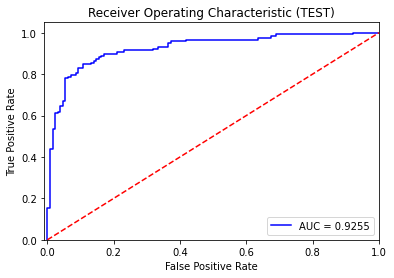

TRAIN accuracy: 0.9719438877755511, precision: 0.9722480641127964, F1: 0.9709543568464729

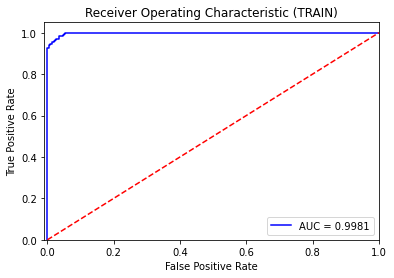

In [0]:
clf = RandomForestClassifier(criterion='gini', max_depth=12, max_features='auto', 
                             min_samples_leaf=1, min_samples_split=5, n_estimators=210, random_state=0)
clf.fit(XTrain_df, yTrain_df)

pred = clf.predict(XTest_df)

accuracy = accuracy_score(y_true=yTest_df, y_pred=pred)
precision = precision_score(y_true=yTest_df, y_pred=pred,average="weighted")
RF1 = metrics.f1_score(yTest_df,pred)

print(f"TEST accuracy: {accuracy}, precision: {precision}, F1: {RF1}")

mlflow.log_metric("accuracy_test", accuracy)
mlflow.log_metric("f1_test", RF1)

prediccionesProb=clf.predict_proba(XTest_df)
fpr, tpr, thresholds = metrics.roc_curve(yTest_df, prediccionesProb[:,1], pos_label=1)
AUC_rf = metrics.auc(fpr, tpr)
mlflow.log_metric("auc_test", AUC_rf)
plt.title('Receiver Operating Characteristic (TEST)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


pred = clf.predict(XTrain_df)
accuracy = accuracy_score(y_true=yTrain_df, y_pred=pred)
precision = precision_score(y_true=yTrain_df, y_pred=pred,average="weighted")
RF1 = metrics.f1_score(yTrain_df,pred)

print(f"TRAIN accuracy: {accuracy}, precision: {precision}, F1: {RF1}")


mlflow.log_metric("accuracy_train", accuracy)
mlflow.log_metric("f1_train", RF1)

prediccionesProb=clf.predict_proba(XTrain_df)
fpr, tpr, thresholds = metrics.roc_curve(yTrain_df, prediccionesProb[:,1], pos_label=1)
plt.title('Receiver Operating Characteristic (TRAIN)')
mlflow.log_metric("auc_train", metrics.auc(fpr, tpr))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % metrics.auc(fpr, tpr))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

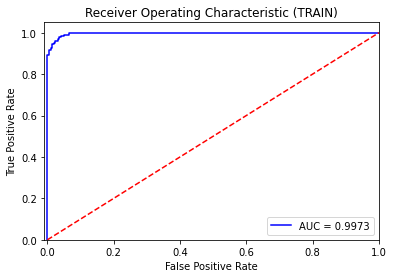

In [0]:
Xtrain_total = pre_processing(Xtotal_df, preprocess_pipeline, numeric_features)
ytrain_total = Ytotal_df
clf.fit(Xtrain_total, ytrain_total)

prediccionesProb=clf.predict_proba(Xtrain_total)
fpr, tpr, thresholds = metrics.roc_curve(ytrain_total, prediccionesProb[:,1], pos_label=1)
plt.title('Receiver Operating Characteristic (TRAIN)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % metrics.auc(fpr, tpr))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [0]:
mlflow.sklearn.log_model(clf, "model")
mlflow.set_tag("owner","Freddy Mendoza")


In [0]:
mlflow.end_run()

In [0]:
mlflow.start_run(experiment_id = "396543035068258")
mlflow.autolog()

2022/04/23 06:24:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/04/23 06:24:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2022/04/23 06:24:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2022/04/23 06:24:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

In [0]:
class RFWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model
        self.categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'] 
        self.numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']
        
        self.n_p = Pipeline([
            ("select_numeric", DataFrameSelector(numeric_features)),
        ])
        
        self.cat_p= Pipeline([
            ("select_cat", DataFrameSelector(categorical_features)),
            ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
        ])
        
        self.p_p = FeatureUnion(transformer_list=[
            ("numerical_pipeline", self.n_p),             
            ("categorical_pipeline", self.cat_p),
        ])
        

    def predict(self, model_input):
        return self.model.predict(self._preprocess_data(model_input))
  
    def _preprocess_data(self, X):
        
        self._df = X.copy()
        self._df = pre_processing(self._df, self.p_p, self.numeric_features)

        return self._df

    def fit(self, X, y):
        self.p_p.fit_transform(X)
        self.model.fit(self._preprocess_data(X), y)

    

In [0]:
XTrain_df, XTest_df, yTrain_df, yTest_df = train_test_split(Xtotal_df, Ytotal_df, test_size=0.33, random_state=0, 
                                                            stratify=Ytotal_df)

rf_model = RandomForestClassifier(criterion='gini', max_depth=12, max_features='auto', 
                             min_samples_leaf=1, min_samples_split=5, n_estimators=210, random_state=0)


myRFmodel = RFWrapper(model = rf_model)

print(myRFmodel)
myRFmodel.fit(XTrain_df, yTrain_df)




<__main__.RFWrapper object at 0x7ffbd056b700>
2022/04/23 06:25:03 WARNING mlflow.utils: Truncated the value of the key `transformer_list`. Truncated value: `[('numerical_pipeline', Pipeline(steps=[('select_numeric',
 DataFrameSelector(attribute_names=['Age', 'RestingBP',
 'Cholesterol', 'MaxHR',
 ...`
2022/04/23 06:25:04 WARNING mlflow.utils: Truncated the value of the key `numerical_pipeline`. Truncated value: `Pipeline(steps=[('select_numeric',
 DataFrameSelector(attribute_names=['Age', 'RestingBP',
 'Cholesterol', 'MaxHR',
 'Oldpeak', '...`
2022/04/23 06:25:04 WARNING mlflow.utils: Truncated the value of the key `categorical_pipeline`. Truncated value: `Pipeline(steps=[('select_cat',
 DataFrameSelector(attribute_names=['Sex', 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 ...`
2022/04/23 06:25:04 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/04/23 06:25:04 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2022/04/23 06:25:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException("Failed to perform one or more operations on the run with ID 7aa9578469994010a387c7b012870361. Failed operations: [RestException('INVALID_PARAMETER_VALUE: Parameter with key verbose was already logged with a value of False. The attempted new value was 0')]")]

In [0]:
pred = myRFmodel.predict(model_input= XTest_df)

accuracy = accuracy_score(y_true=yTest_df, y_pred=pred)
precision = precision_score(y_true=yTest_df, y_pred=pred,average="weighted")
RF1 = metrics.f1_score(yTest_df,pred)

print(f"TEST accuracy: {accuracy}, precision: {precision}, F1: {RF1}")

mlflow.log_metric("accuracy_test", accuracy)
mlflow.log_metric("f1_test", RF1)

pred = myRFmodel.predict(model_input= XTrain_df)


accuracy = accuracy_score(y_true=yTrain_df, y_pred=pred)
precision = precision_score(y_true=yTrain_df, y_pred=pred,average="weighted")
RF1 = metrics.f1_score(yTrain_df,pred)

print(f"TRAIN accuracy: {accuracy}, precision: {precision}, F1: {RF1}")

mlflow.log_metric("accuracy_train", accuracy)
mlflow.log_metric("f1_train", RF1)


TEST accuracy: 0.8623481781376519, precision: 0.8623439153495539, F1: 0.8547008547008546
TRAIN accuracy: 0.9719438877755511, precision: 0.9722480641127964, F1: 0.9709543568464729

In [0]:
rf_model = RandomForestClassifier(criterion='gini', max_depth=12, max_features='auto', 
                             min_samples_leaf=1, min_samples_split=5, n_estimators=210, random_state=0)


myRFmodel = RFWrapper(model = rf_model)
myRFmodel.fit(Xtotal_df, Ytotal_df)


2022/04/23 06:25:16 WARNING mlflow.utils: Truncated the value of the key `transformer_list`. Truncated value: `[('numerical_pipeline', Pipeline(steps=[('select_numeric',
 DataFrameSelector(attribute_names=['Age', 'RestingBP',
 'Cholesterol', 'MaxHR',
 ...`
2022/04/23 06:25:16 WARNING mlflow.utils: Truncated the value of the key `numerical_pipeline`. Truncated value: `Pipeline(steps=[('select_numeric',
 DataFrameSelector(attribute_names=['Age', 'RestingBP',
 'Cholesterol', 'MaxHR',
 'Oldpeak', '...`
2022/04/23 06:25:16 WARNING mlflow.utils: Truncated the value of the key `categorical_pipeline`. Truncated value: `Pipeline(steps=[('select_cat',
 DataFrameSelector(attribute_names=['Sex', 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 ...`
2022/04/23 06:25:16 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/04/23 06:25:16 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2022/04/23 06:25:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException("Failed to perform one or more operations on the run with ID 7aa9578469994010a387c7b012870361. Failed operations: [RestException('INVALID_PARAMETER_VALUE: Parameter with key verbose was already logged with a value of False. The attempted new value was 0')]")]

In [0]:
mlflow.sklearn.log_model(myRFmodel, "model", input_example=Xtotal_df.head(5))

mlflow.set_tag("owner","Freddy Mendoza")

In [0]:
mlflow.end_run()

In [0]:
logged_model = 'runs:/7aa9578469994010a387c7b012870361/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


data_new = np.array([[40,'M','ATA',140,289,0,'Normal',172,'N',0,'Up'], 
          [49,'F','NAP',160,180,0,'Normal',156,'N',1,'Flat'],
          [37,'M','ATA',130,283,0,'ST',98,'N',0,'Up']])

df = pd.DataFrame(data_new,columns=['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope']).astype(dtype={'Age':'int','RestingBP':'int', 'Cholesterol':'int', 'FastingBS':'int', 'MaxHR':'int', 'Oldpeak':'float'})


df["HeartDisease"] = loaded_model.predict(df)
df



Out[229]:

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


In [0]:
model_name = "ml2_tp_rf2"
result = mlflow.register_model("runs:/7aa9578469994010a387c7b012870361/model",model_name)

Registered model 'ml2_tp_rf2' already exists. Creating a new version of this model...
2022/04/23 06:27:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: ml2_tp_rf2, version 3
Created version '3' of model 'ml2_tp_rf2'.

## Registrar modelo

In [0]:
model_name = "ml2_tp_rf"
result = mlflow.register_model("runs:/b7be2e95b88b48fd84e2b3dd5c08776d/model",model_name)

Registered model 'ml2_tp_rf' already exists. Creating a new version of this model...
2022/04/23 05:46:24 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: ml2_tp_rf, version 3
Created version '3' of model 'ml2_tp_rf'.

In [0]:
#stage = "Production"
stage = "Staging"
#stage = "None"

model = mlflow.sklearn.load_model(
    model_uri=f"models:/ml2_tp_rf/{stage}"
)

In [0]:
model

Out[218]: RandomForestClassifier(max_depth=12, min_samples_split=5, n_estimators=210,
 random_state=0)

## Predicciones

In [0]:
data_new = np.array([[40,'M','ATA',140,289,0,'Normal',172,'N',0,'Up'], 
          [49,'F','NAP',160,180,0,'Normal',156,'N',1,'Flat'],
          [37,'M','ATA',130,283,0,'ST',98,'N',0,'Up']])

df = pd.DataFrame(data_new,columns=['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope']).astype(dtype={'Age':'int','RestingBP':'int', 'Cholesterol':'int', 'FastingBS':'int', 'MaxHR':'int', 'Oldpeak':'float'})


df["HeartDisease"] = model.predict(pre_processing(df, preprocess_pipeline, numeric_features))

df

Out[219]:

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


In [0]:
spark.createDataFrame(df).select('*').write.format('jdbc')\
    .mode('append')\
    .option("url", "jdbc:postgresql://34.134.192.243:5432/ml2")\
    .option("dbtable", "heart_predictions")\
    .option("user", "postgres")\
    .option("password", "vjoDsrpnzad7rlnG")\
    .option("driver", "org.postgresql.Driver")\
    .save()